In [1]:
import pandas as pd
import numpy as np
from glob import glob
from pytorch_pretrained_bert import BertTokenizer
import torch
from torch import nn
%matplotlib inline
import json
from tqdm import tqdm
from sklearn import metrics

from model import BertPunc
from data import load_file, preprocess_data, create_data_loader

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


### Model path

In [2]:
glob('models/*')

['models/20190418_211742', 'models/20190419_162056']

In [3]:
path = 'models/20190418_211742/'

### Prepare

In [4]:
data_test = load_file('data/LREC/test2011')
data_test_asr = load_file('data/LREC/test2011asr')
# data_test = load_file('data/NPR-podcasts/test')

In [5]:
with open(path+'hyperparameters.json', 'r') as f:
    hyperparameters = json.load(f)
hyperparameters

{'segment_size': 32,
 'dropout': 0.3,
 'epochs_top': 3,
 'iterations_top': 2,
 'learning_rate_top': 1e-05,
 'epochs_all': 6,
 'iterations_all': 3,
 'batch_size_all': 256,
 'learning_rate_all': 1e-05}

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

punctuation_enc = {
    'O': 0,
    'COMMA': 1,
    'PERIOD': 2,
    'QUESTION': 3
}

# punctuation_enc = {
#     'O': 0,
#     'PERIOD': 1
# }

segment_size = hyperparameters['segment_size']

In [7]:
X_test, y_test = preprocess_data(data_test, tokenizer, punctuation_enc, segment_size)
X_test_asr, y_test_asr = preprocess_data(data_test_asr, tokenizer, punctuation_enc, segment_size)

In [8]:
output_size = len(punctuation_enc)
dropout = hyperparameters['dropout']
bert_punc = nn.DataParallel(BertPunc(segment_size, output_size, dropout).cuda())

### Model progress

In [9]:
progress = pd.read_csv(path+'progress.csv', delimiter=';')
progress

,time,epoch,iteration,training loss,loss,accuracy,f1_space,f1_comma,f1_period,f1_question
0,2019-04-18 21:44:48,1,1,0.2064,0.2202,0.9190,0.9673,0.4420,0.6838,0.2902
1,2019-04-18 22:11:29,1,2,0.2059,0.2081,0.9230,0.9697,0.5008,0.6921,0.3547
2,2019-04-18 22:38:09,2,1,0.2241,0.2063,0.9241,0.9702,0.5048,0.6938,0.3921
3,2019-04-18 23:04:47,2,2,0.2088,0.2035,0.9261,0.9716,0.5237,0.7039,0.3801
4,2019-04-18 23:31:14,3,1,0.2310,0.2038,0.9253,0.9712,0.5196,0.7009,0.4100
5,2019-04-18 23:57:38,3,2,0.2127,0.2049,0.9256,0.9716,0.5182,0.7024,0.4047
6,2019-04-19 00:46:02,1,1,0.1363,0.1382,0.9475,0.9815,0.6405,0.7768,0.3154
7,2019-04-19 01:33:46,1,2,0.1411,0.1323,0.9499,0.9825,0.6586,0.7866,0.3189
8,2019-04-19 02:21:28,1,3,0.1906,0.1283,0.9503,0.9830,0.6709,0.7898,0.3295
9,2019-04-19 03:09:11,2,1,0.1304,0.1283,0.9511,0.9832,0.6800,0.7911,0.3349


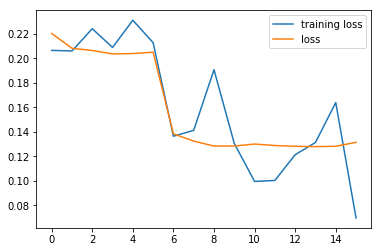

In [10]:
progress[['training loss', 'loss']].plot();

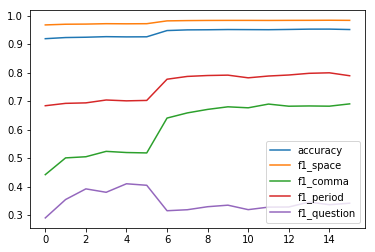

In [11]:
progress[['accuracy', 'f1_space', 'f1_comma', 'f1_period', 'f1_question']].plot();
# progress[['accuracy', 'f1_O', 'f1_PERIOD']].plot();

### Model evaluation

In [12]:
bert_punc.load_state_dict(torch.load(path+'model'))
bert_punc.eval();

In [13]:
batch_size = 1024
data_loader_test = create_data_loader(X_test, y_test, False, batch_size)
data_loader_test_asr = create_data_loader(X_test_asr, y_test_asr, False, batch_size)

In [14]:
def predictions(data_loader):
    y_pred = []
    y_true = []
    for inputs, labels in tqdm(data_loader, total=len(data_loader)):
        with torch.no_grad():
            inputs, labels = inputs.cuda(), labels.cuda()
            output = bert_punc(inputs)
            y_pred += list(output.argmax(dim=1).cpu().data.numpy().flatten())
            y_true += list(labels.cpu().data.numpy().flatten())
    return y_pred, y_true

In [15]:
def evaluation(y_pred, y_test):
    precision, recall, f1, _ = metrics.precision_recall_fscore_support(
        y_test, y_pred, average=None, labels=[1, 2, 3])
    overall = metrics.precision_recall_fscore_support(
        y_test, y_pred, average='macro', labels=[1, 2, 3])
    result = pd.DataFrame(
        np.array([precision, recall, f1]), 
        columns=list(punctuation_enc.keys())[1:], 
        index=['Precision', 'Recall', 'F1']
    )
    result['OVERALL'] = overall[:3]
    return result

In [16]:
# def evaluation(y_pred, y_test):
#     precision, recall, f1, _ = metrics.precision_recall_fscore_support(
#         y_test, y_pred, average=None, labels=[1])
#     overall = metrics.precision_recall_fscore_support(
#         y_test, y_pred, average='macro', labels=[1])
#     result = pd.DataFrame(
#         np.array([precision, recall, f1]), 
#         columns=list(punctuation_enc.keys())[1:], 
#         index=['Precision', 'Recall', 'F1']
#     )
#     result['OVERALL'] = overall[:3]
#     return result

#### Test

In [17]:
y_pred_test, y_true_test = predictions(data_loader_test)
eval_test = evaluation(y_pred_test, y_true_test)
eval_test

100%|██████████| 14/14 [00:12<00:00,  1.57it/s]


,COMMA,PERIOD,QUESTION,OVERALL
Precision,0.670927,0.819083,0.708333,0.732781
Recall,0.759036,0.819083,0.739130,0.772417
F1,0.712267,0.819083,0.723404,0.751585


In [18]:
# https://www.isca-speech.org/archive/Interspeech_2016/pdfs/1517.PDF
ref_test = pd.DataFrame({
    'COMMA':    [0.655, 0.471, 0.548],
    'PERIOD':   [0.733, 0.725, 0.729],
    'QUESTION': [0.707, 0.630, 0.667],
    'OVERALL':  [0.700, 0.597, 0.644]
}, index=['Precision', 'Recall', 'F1'])
ref_test

,COMMA,PERIOD,QUESTION,OVERALL
Precision,0.655,0.733,0.707,0.700
Recall,0.471,0.725,0.630,0.597
F1,0.548,0.729,0.667,0.644


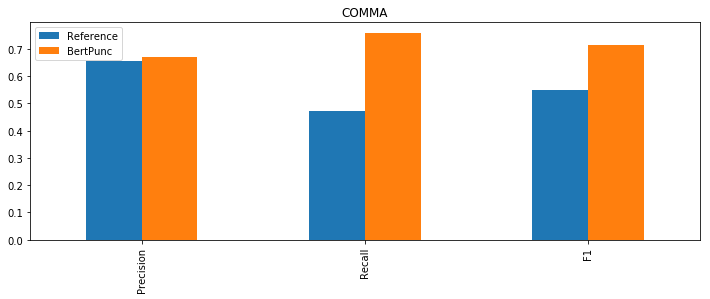

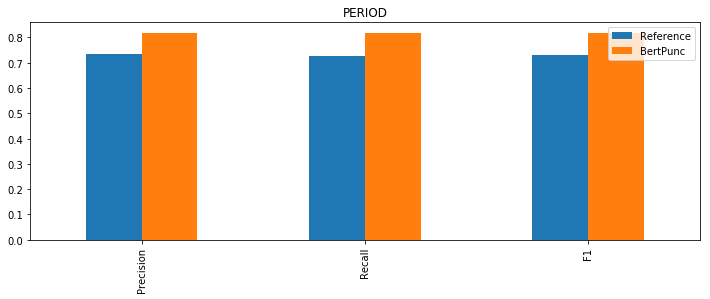

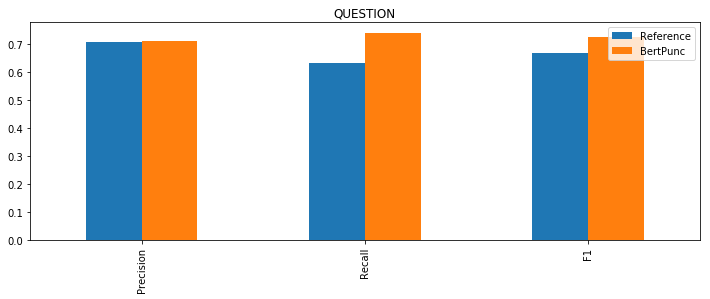

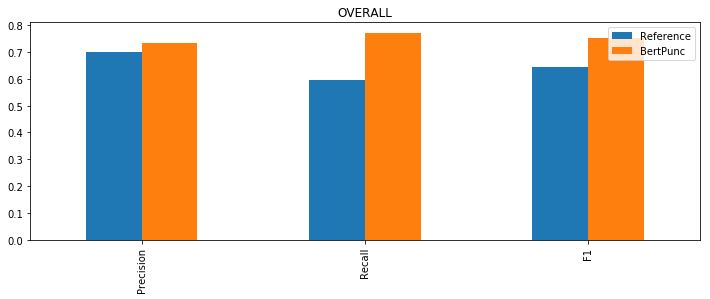

In [19]:
for col in ref_test.columns:
    pd.DataFrame({'Reference': ref_test[col], 'BertPunc': eval_test[col]}).plot.bar(
        title=col, figsize=(12, 4))

#### Test ASR

In [20]:
y_pred_test_asr, y_true_test_asr = predictions(data_loader_test_asr)
eval_test_asr = evaluation(y_pred_test_asr, y_true_test_asr)
eval_test_asr

100%|██████████| 14/14 [00:09<00:00,  1.64it/s]


,COMMA,PERIOD,QUESTION,OVERALL
Precision,0.485539,0.771995,0.469388,0.575641
Recall,0.694236,0.770087,0.657143,0.707155
F1,0.571429,0.771040,0.547619,0.630029


In [21]:
# https://www.isca-speech.org/archive/Interspeech_2016/pdfs/1517.PDF
ref_test_asr = pd.DataFrame({
    'COMMA':    [0.596, 0.429, 0.499],
    'PERIOD':   [0.707, 0.720, 0.714],
    'QUESTION': [0.607, 0.486, 0.540],
    'OVERALL':  [0.660, 0.573, 0.614]
}, index=['Precision', 'Recall', 'F1'])
ref_test_asr

,COMMA,PERIOD,QUESTION,OVERALL
Precision,0.596,0.707,0.607,0.660
Recall,0.429,0.720,0.486,0.573
F1,0.499,0.714,0.540,0.614


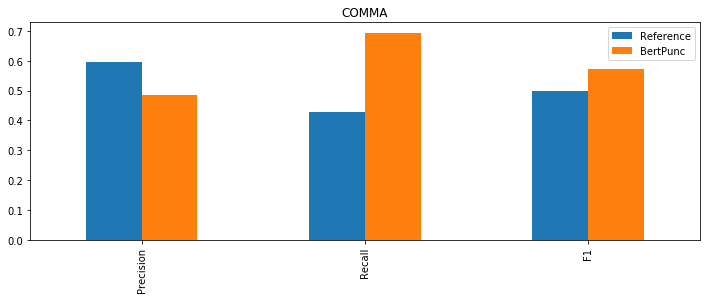

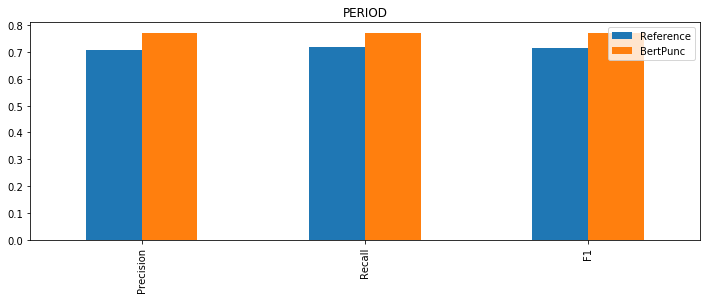

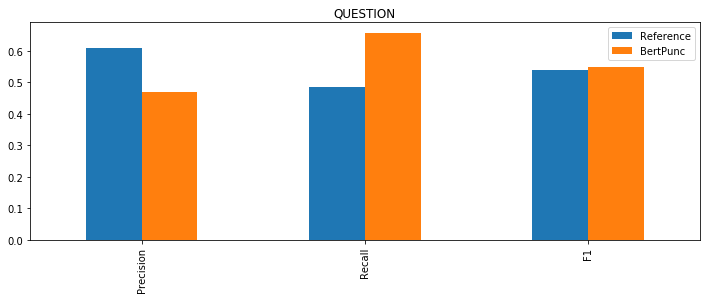

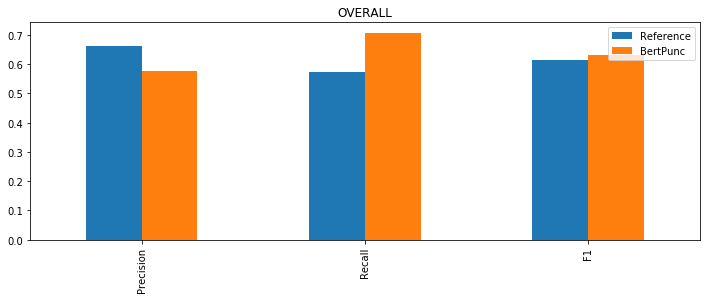

In [22]:
for col in ref_test_asr.columns:
    pd.DataFrame({'Reference': ref_test_asr[col], 'BertPunc': eval_test_asr[col]}).plot.bar(
        title=col, figsize=(12, 4))